In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

In [10]:

model = load_model("denoiser_unet_model.h5")


In [11]:

img_height = 64
img_width = 64



In [12]:

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting for alignment
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)
    return np.array(images)


In [14]:

# Load your test data
noisy_images = load_images_from_folder(r"E:/Code/project/Chana/Code/Image Denoising via Outlier Detection using CNN-U-Net Hybrid Model/images_test/noisy/test")
clean_images = load_images_from_folder(r"E:/Code/project/Chana/Code/Image Denoising via Outlier Detection using CNN-U-Net Hybrid Model/images_test/clean/test")  # Optional, for comparison

In [15]:
print("Shape of noisy_images:", noisy_images.shape)


Shape of noisy_images: (300, 64, 64, 3)


In [16]:
denoised_images = model.predict(noisy_images)


10/10 [==============================] - 5s 419ms/step


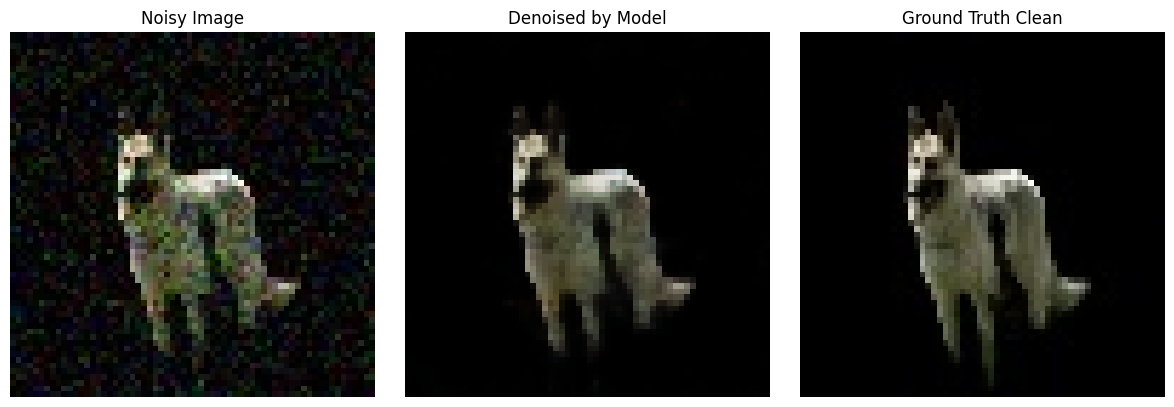

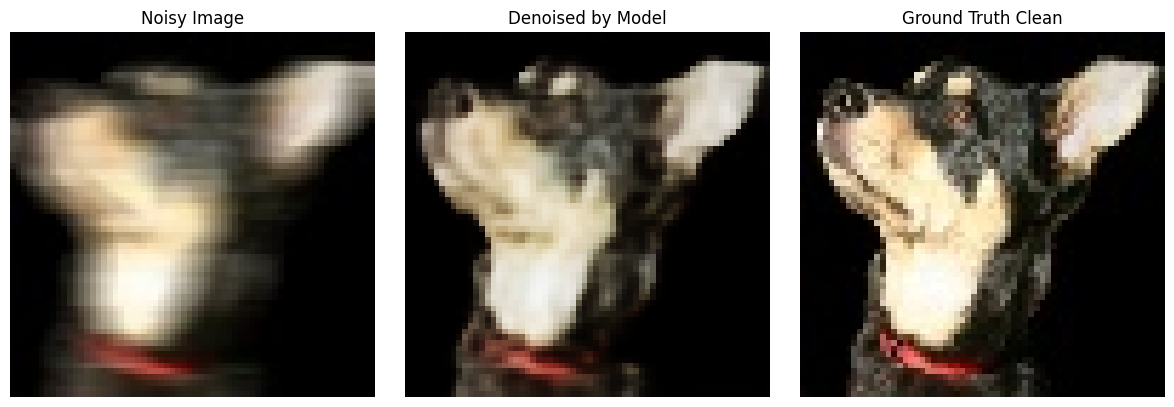

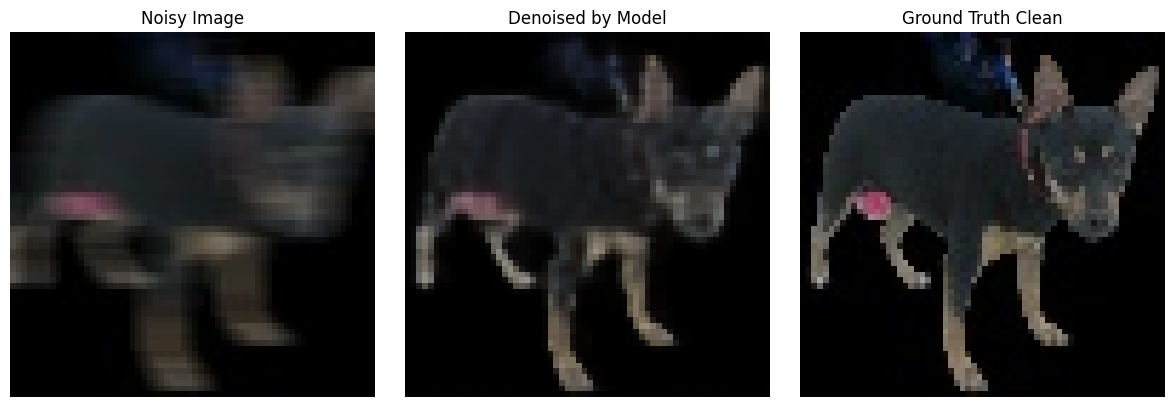

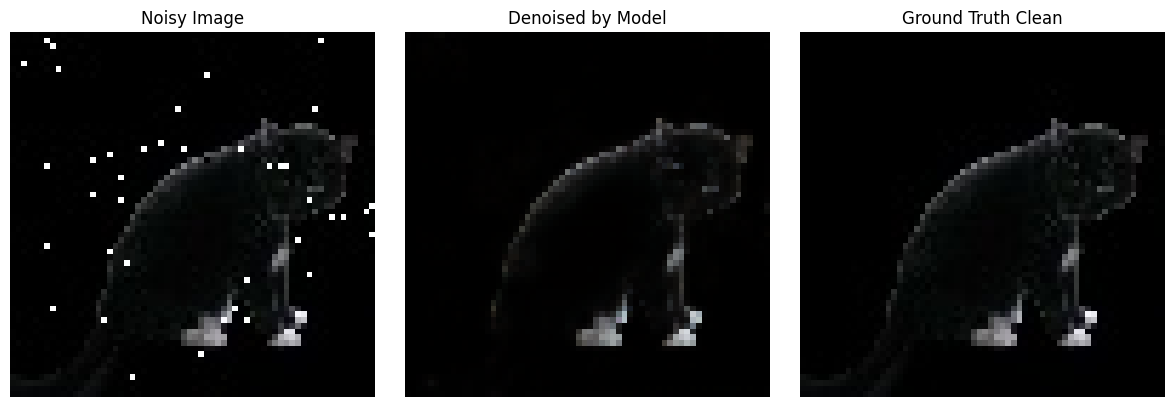

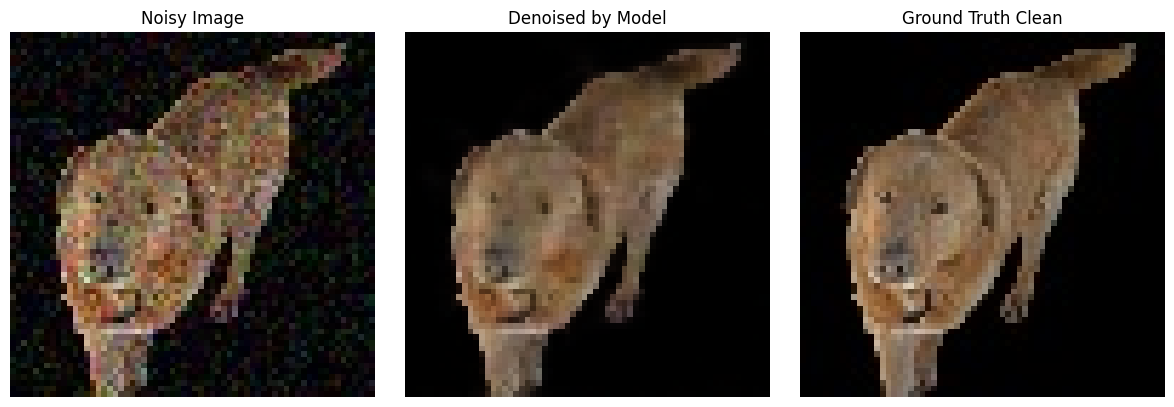

In [17]:
num_samples = 5

random_indices = random.sample(range(len(noisy_images)), num_samples)

for i in random_indices:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_images[i])
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(denoised_images[i])
    plt.title("Denoised by Model")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    if i < len(clean_images):
        plt.imshow(clean_images[i])
        plt.title("Ground Truth Clean")
    else:
        plt.title("No Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [18]:
def calculate_psnr_tf(y_true, y_pred):
    psnr_val = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_val).numpy()


In [19]:
def calculate_ssim_tf(y_true, y_pred):
    ssim_val = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_val).numpy()


In [20]:
# Lists to store SSIM and PSNR values
ssim_vals = []
psnr_vals = []

In [21]:
total_ssim = 0.0
total_psnr = 0.0

In [22]:
n = len(clean_images)

for i in range(n):
    y_true = tf.convert_to_tensor(clean_images[i:i+1], dtype=tf.float32)
    y_pred = tf.convert_to_tensor(denoised_images[i:i+1], dtype=tf.float32)
    
    
    ssim_value = calculate_ssim_tf(y_true, y_pred)
    psnr_value = calculate_psnr_tf(y_true, y_pred)
    
    
    ssim_vals.append(ssim_value)
    psnr_vals.append(psnr_value)
    
    
    total_ssim += ssim_value
    total_psnr += psnr_value
    


In [23]:
avg_ssim = total_ssim / n
avg_psnr = total_psnr / n

print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average PSNR: {avg_psnr:.2f} dB")

Average SSIM: 0.8936
Average PSNR: 29.48 dB


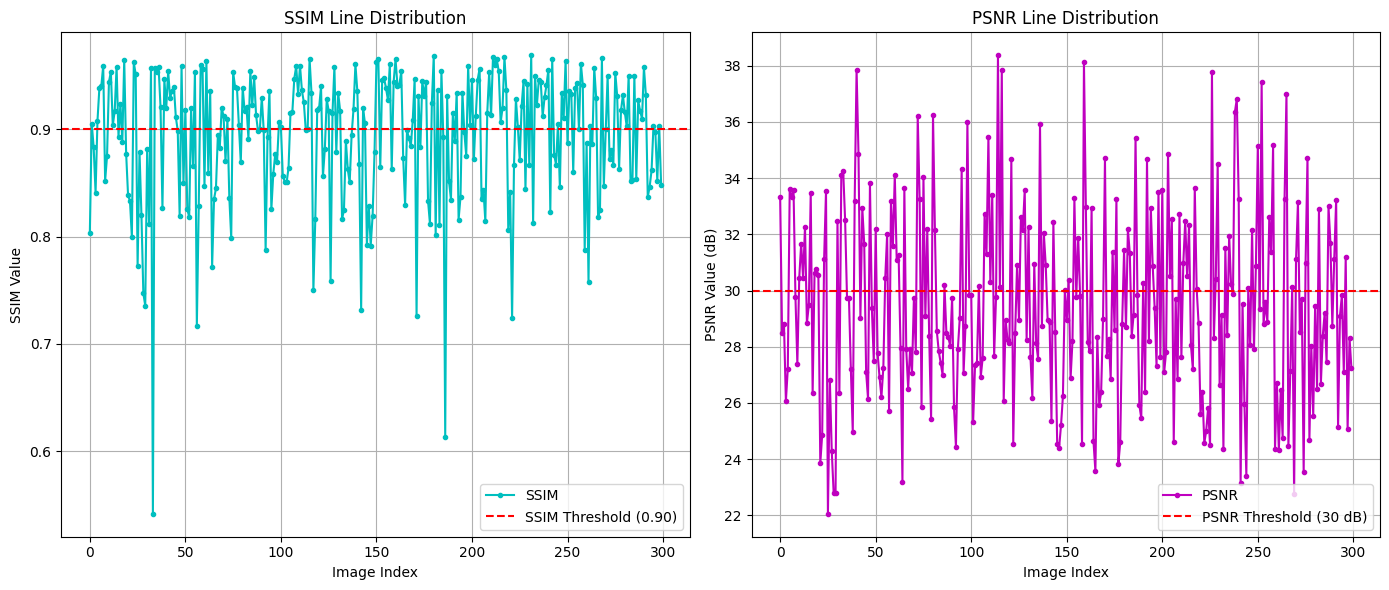

In [24]:
# Plot SSIM and PSNR values
plt.figure(figsize=(14, 6))

# SSIM Line Plot
plt.subplot(1, 2, 1)
plt.plot(ssim_vals, color='c', label='SSIM', marker='o', markersize=3)
plt.title('SSIM Line Distribution')
plt.xlabel('Image Index')
plt.ylabel('SSIM Value')
plt.axhline(y=0.90, color='r', linestyle='--', label='SSIM Threshold (0.90)')
plt.legend(loc='lower right')
plt.grid(True)

# PSNR Line Plot
plt.subplot(1, 2, 2)
plt.plot(psnr_vals, color='m', label='PSNR', marker='o', markersize=3)
plt.title('PSNR Line Distribution')
plt.xlabel('Image Index')
plt.ylabel('PSNR Value (dB)')
plt.axhline(y=30, color='r', linestyle='--', label='PSNR Threshold (30 dB)')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


## RECONSTRUCTION ERROR (MSE) & OUTLIER DETECTION

In [25]:
reconstruction_errors = []

for i in range(len(clean_images)):
    mse = tf.reduce_mean(tf.square(clean_images[i] - denoised_images[i]))
    reconstruction_errors.append(mse.numpy())

reconstruction_errors = np.array(reconstruction_errors)

In [26]:
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)
threshold = mean_error + 2 * std_error

In [27]:
outliers = [i for i, error in enumerate(reconstruction_errors) if error > threshold]

In [28]:
print(f"\n--- Outlier Detection Summary ---")
print(f"Mean Reconstruction Error: {mean_error:.6f}")
print(f"Standard Deviation: {std_error:.6f}")
print(f"Threshold for Outliers: {threshold:.6f}")
print(f"Number of Outlier Images Detected: {len(outliers)}")


--- Outlier Detection Summary ---
Mean Reconstruction Error: 0.001488
Standard Deviation: 0.001105
Threshold for Outliers: 0.003697
Number of Outlier Images Detected: 13


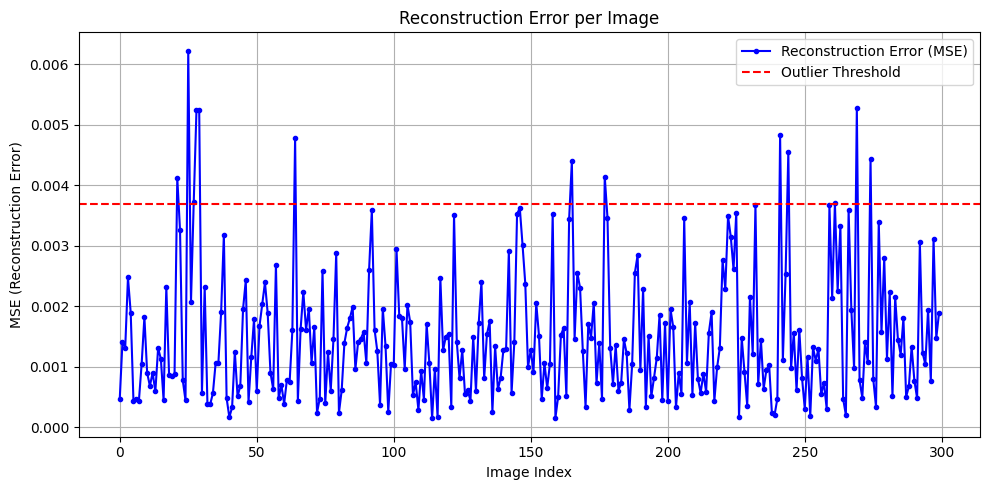

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors, color='blue', label='Reconstruction Error (MSE)', marker='o', markersize=3)
plt.axhline(y=threshold, color='red', linestyle='--', label='Outlier Threshold')
plt.title("Reconstruction Error per Image")
plt.xlabel("Image Index")
plt.ylabel("MSE (Reconstruction Error)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Show a few outlier images

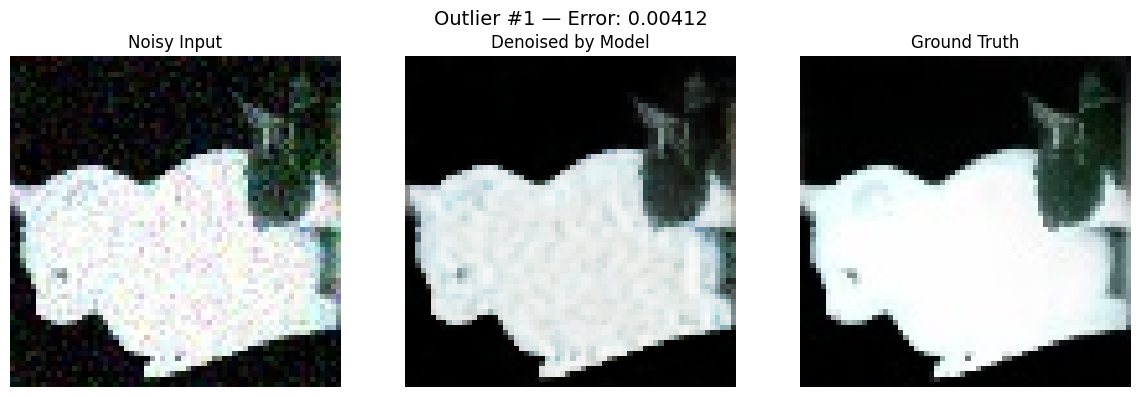

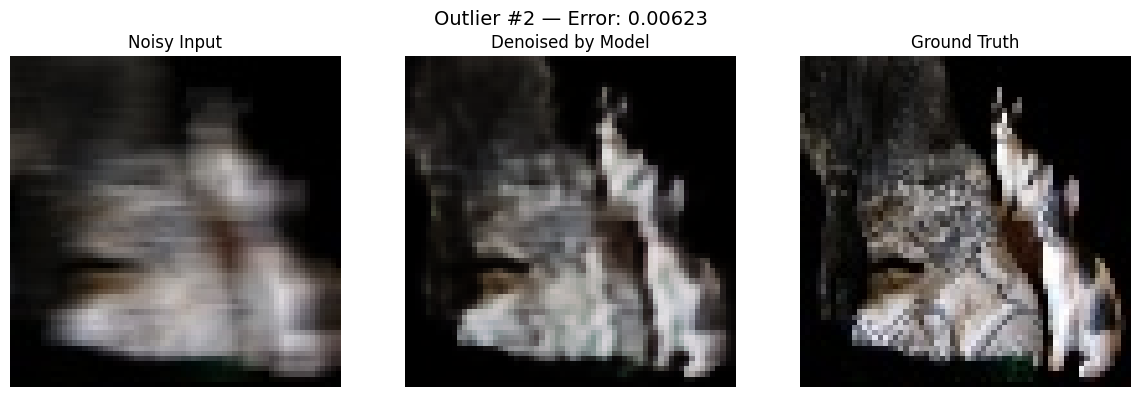

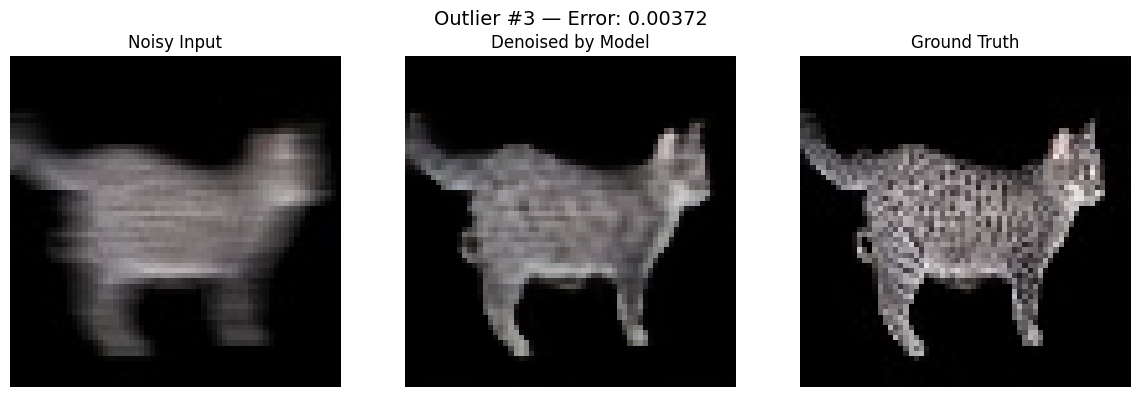

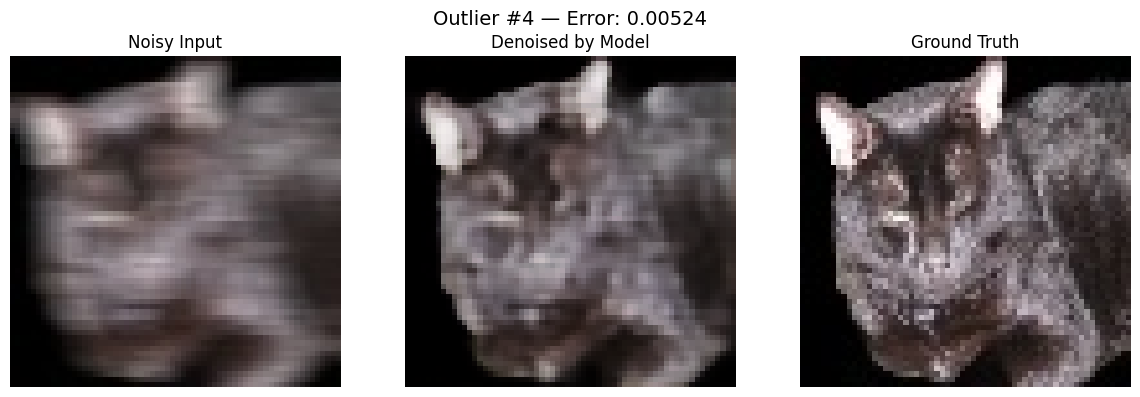

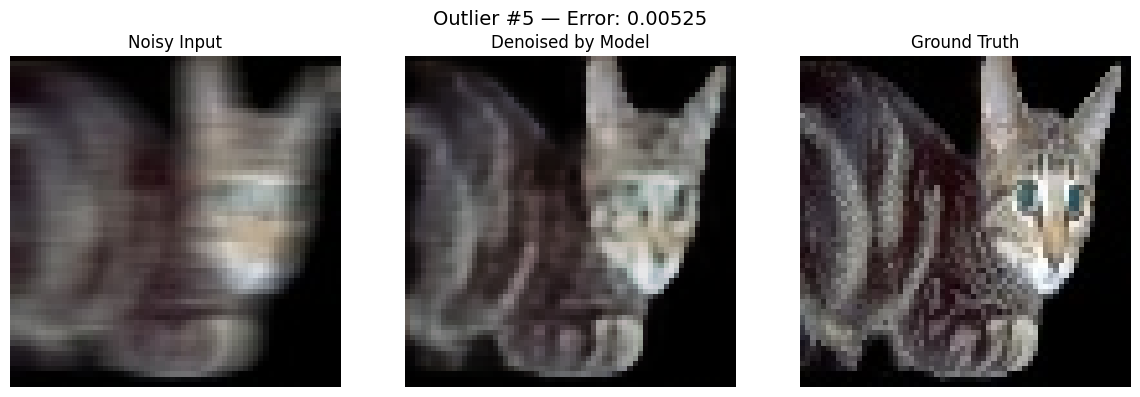

In [30]:
num_outliers_to_show = min(5, len(outliers))

for i in range(num_outliers_to_show):
    idx = outliers[i]
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_images[idx])
    plt.title("Noisy Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(denoised_images[idx])
    plt.title("Denoised by Model")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(clean_images[idx])
    plt.title("Ground Truth")
    plt.axis("off")

    plt.suptitle(f"Outlier #{i+1} — Error: {reconstruction_errors[idx]:.5f}", fontsize=14)
    plt.tight_layout()
    plt.show()
